# Predicting CMS Prevalence of Diabetes at County Level based on AHRQ Social Determinants of Health 


__[GitHub: SocialHealthAI/SDOH-Models](https://github.com/SocialHealthAI/SDOH-Models)__

## Overview
The target for the models is the prevalence (percent) of diabetes at the county level.  Prevalence data is obtained from the Center of Medicare and Medicaid Services (CMS) diabetes claims.  The features are social determinants of health (SDOH) obtained from the  Agency for Healthcare Research and Quality (AHRQ).

# Set up Environment

In [1]:
%run ../../environment/env1.ipynb

# Extract, transform and load data

## CMS Diabetes Prevalence
Call CMS Chronic Data notebook using year and disease parameters.

In [2]:
parm_CMSChronic_disease = 'Diabetes'
parm_CMSChronic_years = ['2015', '2016', '2017', '2018']
%run ../../etl/dataCMSChronic.ipynb
dfCMSChronicPrevalence = out_CMSChronic()

## Explore CMS Data
Show prevalence in sorted barchart for particular state.

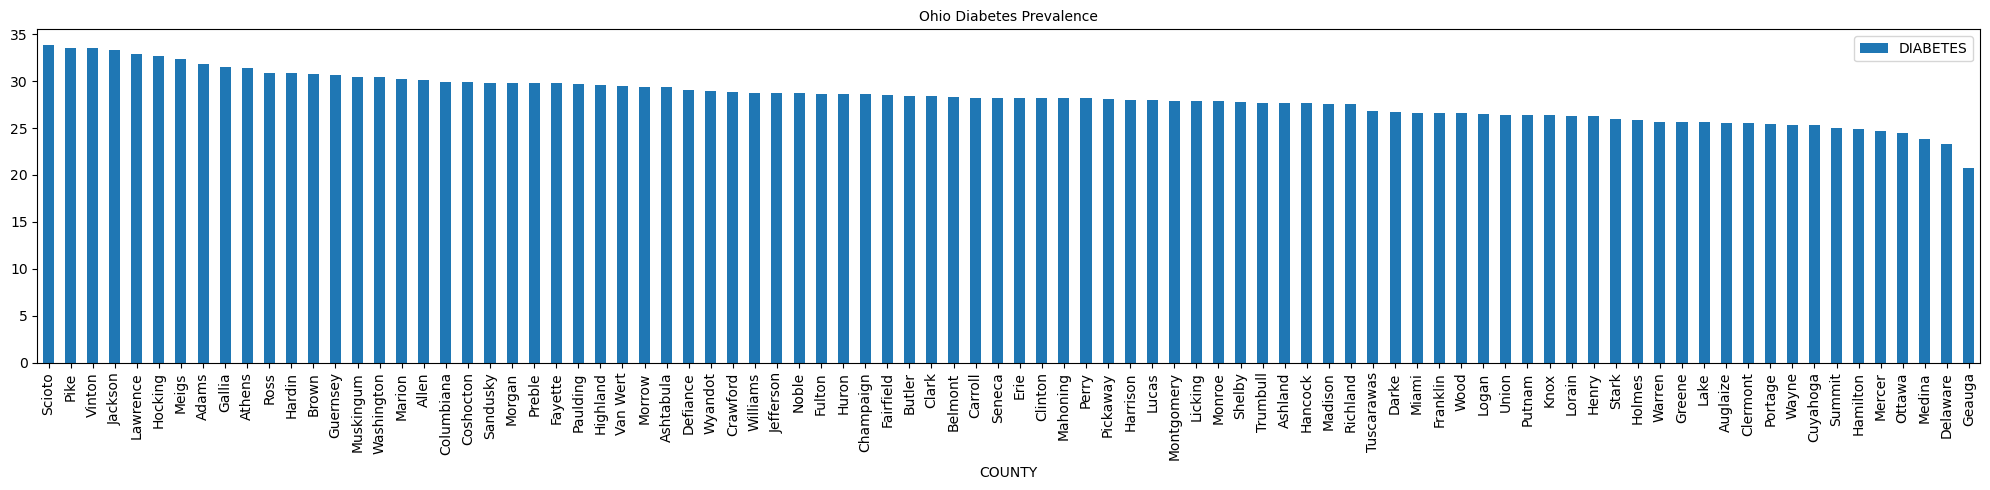

In [3]:
dfDisplay = dfCMSChronicPrevalence[(dfCMSChronicPrevalence.STATE == 'Ohio') & (dfCMSChronicPrevalence.YEAR == 2018)]
dfDisplay= dfDisplay.sort_values('DIABETES',ascending=False)
dfDisplay.plot(x="COUNTY", y="DIABETES", kind="bar", figsize=(20,5))
plt.title("Ohio Diabetes Prevalence", fontsize=10)
plt.tight_layout()
plt.show()

## AHRQ Social Determinants of Health Data
Call AHRQ SDOH Data notebook using year parameter.

In [4]:
parm_AHRQCountySDOH_years = ['2015', '2016', '2017', '2018']
# currently not including NOAAC - temperature by month
parm_AHRQCountySDOH_surveys = ["ACS", "AHA", "AMFAR", "CCBP", "CDCSVI", "CEN", "CRDC", "EPAA", "FARA", "FEA", "HHC", "HIFLD", "HRSA", "MHSVI", "MP", "NCHS", "NEPHTN", "NHC", "NOAAS", "POS", "SAHIE", "SAIPE", "SEDA"]
parm_AHRQCountySDOH_questions = ["CDCW_INJURY_DTH_RATE", "CDCW_TRANSPORT_DTH_RATE", "CDCW_SELFHARM_DTH_RATE", "CDCW_ASSAULT_DTH_RATE", "CHR_TOT_MENTAL_PROV", "CHR_MENTAL_PROV_RATE", "CHR_SEGREG_BLACK", "CHR_PCT_ALCOHOL_DRIV_DEATH", "CHR_PCT_EXCESS_DRINK", "CHR_PCT_FOOD", "CHR_SEGREG_BLACK", "CHR_SEGREG_NON_WHITE"]
%run ../../etl/dataAHRQCountySDOH.ipynb
dfAHRQCountySDOH = out_AHRQCountySDOH()

## Explore AHRQ Data
Show correlations for food related SDOH.

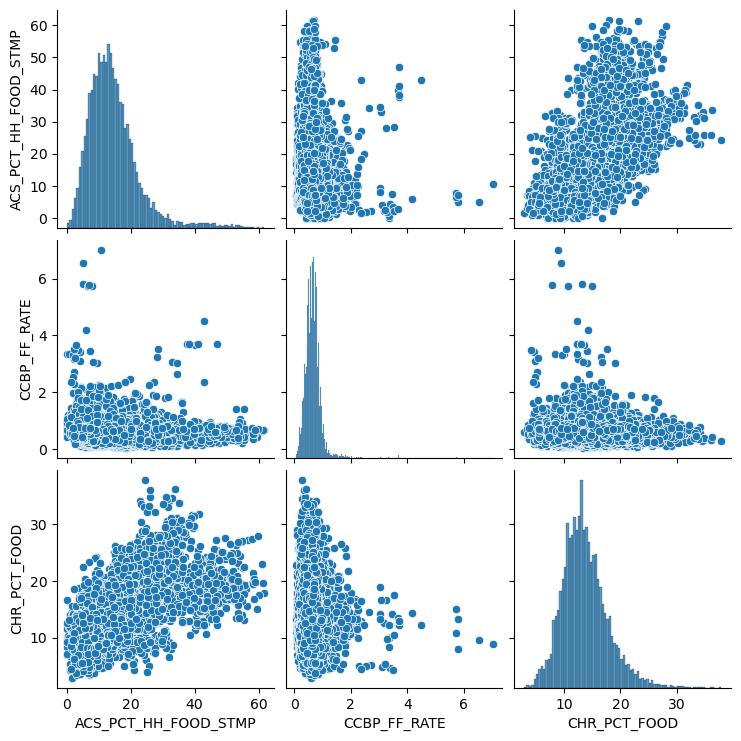

In [5]:
dfAHRQFood = dfAHRQCountySDOH[['STATE', 'COUNTY', 'ACS_PCT_HH_FOOD_STMP', 'CCBP_FF_RATE', 'CHR_PCT_FOOD']]
sns.pairplot(dfAHRQFood)

## Merge Data

In [6]:
dfMerged = pd.merge(dfAHRQCountySDOH, dfCMSChronicPrevalence, how='inner', left_on=['STATE','COUNTY', 'YEAR'], right_on = ['STATE','COUNTY', 'YEAR'])
dfMerged = dfMerged[dfMerged['YEAR'] < 2018]

X = dfMerged.drop(["DIABETES", "STATE", "COUNTY", "FIPS", "YEAR"], axis = 1)
Y = dfMerged["DIABETES"]

# Feature Selection

## Random Forest Regressor feature selection

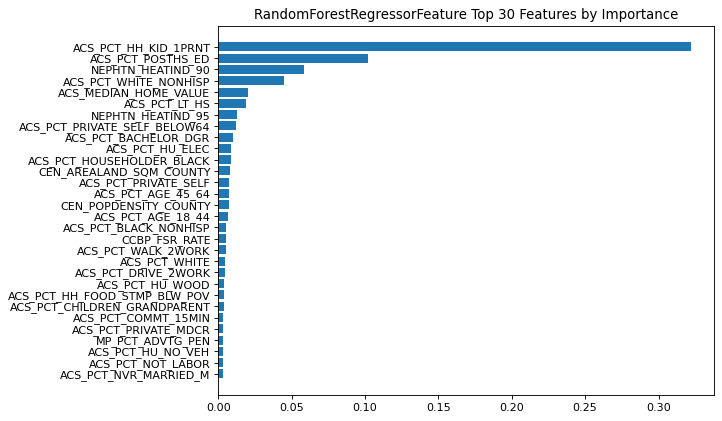

In [7]:
parm_features_RandomForestReg_X = X # features dataframe
parm_features_RandomForestReg_Y = Y # target dataframe

%run ../../features/features_RandomForestReg.ipynb
listSelectedFeatures = out_features_RandomForestReg_X()

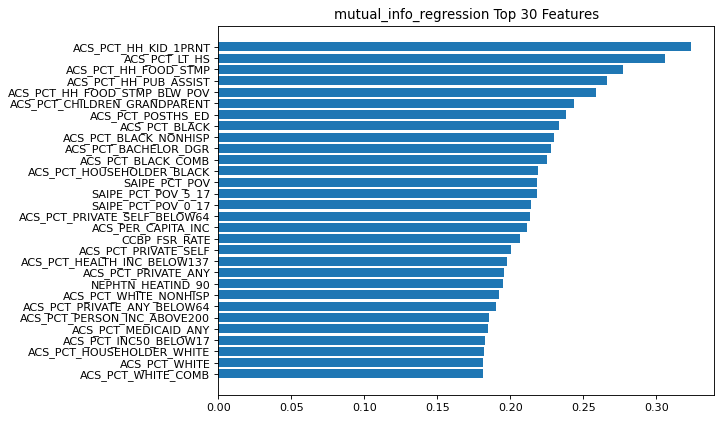

In [8]:
parm_features_MutualInformationReg_X = X # features dataframe
parm_features_MutualInformationReg_Y = Y # target dataframe
%run ../../features/features_MutualInformationReg.ipynb
#listSelectedFeatures = out_features_MutualInformationReg_X()[0:30]

## Use the selected features

In [9]:
X_selected = X[listSelectedFeatures]

# Develop Models and Evaluate Performance

## Linear Regression
Use 5 fold cross validation for training and test data sets and only selected features.  Shuffle the data first so the order of data does not influence
the 5 holdout data sets.

In [10]:
lr = LinearRegression()
X_shuffle, Y_shuffle = shuffle(X_selected, Y, random_state=42)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_shuffle, Y_shuffle,
                         scoring="r2",
                         cv=5, n_jobs=1)

print( "R2 Score", np.mean(scores)) 

R2 Score 0.7281436606435143


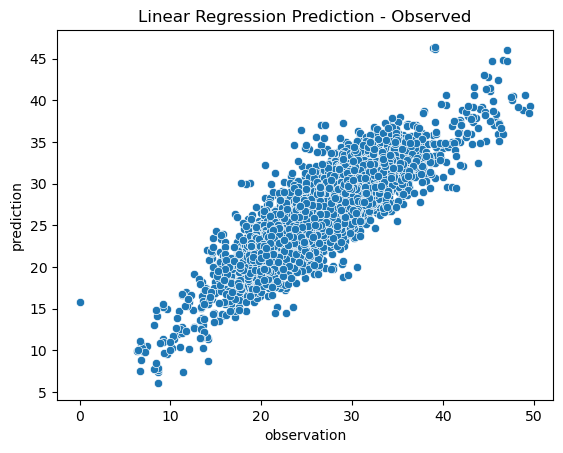

In [11]:
lr.fit(X_selected, Y)
Y_pred = lr.predict(X_selected)

Y_list = Y.tolist()
scatterplot(x=Y_list, y=Y_pred)
plt.title('Linear Regression Prediction - Observed')
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

## Random Forest
Use all features. Training and test data sets are not necessary as random forest uses 2/3 of the data to grow each tree and the remaining 1/3 is used to calculate out-of-bag error to compute the model performance.

In [12]:
# define the model
rf = RandomForestRegressor(n_estimators= 20, random_state=5)
# fit the random forest model
rf.fit(X, Y)

RandomForestRegressor(n_estimators=20, random_state=5)

R2 Score:  0.9812007084869648


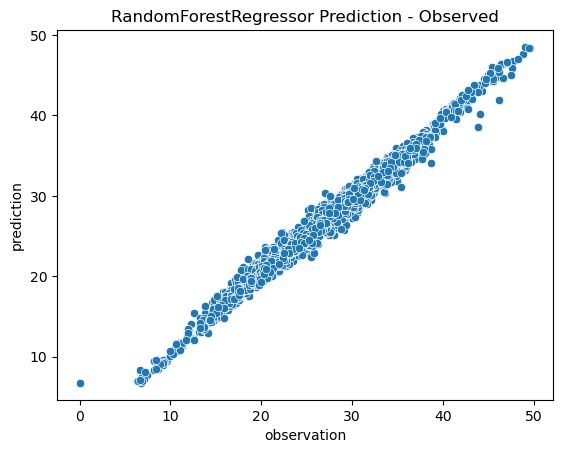

In [13]:
Y_pred = rf.predict(X)
print("R2 Score: ", r2_score(Y,Y_pred))

Y_list = Y.tolist()
scatterplot(x=Y_list, y=Y_pred)
plt.title('RandomForestRegressor Prediction - Observed')
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

## Boosted Trees
Use all features. Training and test data sets are necessary so we use 5 fold cross validation.

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
xgb = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=0)

scores = cross_val_score(xgb, X_shuffle, Y_shuffle,
                         scoring="r2",
                         cv=5, n_jobs=1)

print( "R2 Score", np.mean(scores)) 

R2 Score 0.7719469748983545


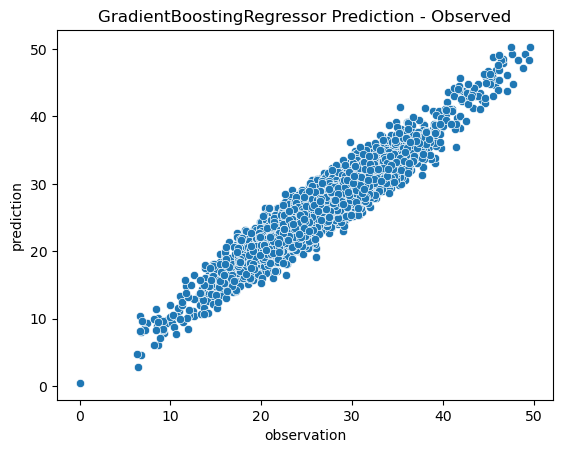

In [15]:
xgb.fit(X, Y)
Y_pred = xgb.predict(X)

Y_list = Y.tolist()
scatterplot(x=Y_list, y=Y_pred)
plt.title('GradientBoostingRegressor Prediction - Observed')
plt.xlabel("observation")
plt.ylabel("prediction")
plt.show()

# Evaluate performance future year

### Create test sets for future year

In [16]:
dfMergedFuture = pd.merge(dfAHRQCountySDOH, dfCMSChronicPrevalence, how='inner', left_on=['STATE','COUNTY', 'YEAR'], right_on = ['STATE','COUNTY', 'YEAR'])
dfMergedFuture = dfMergedFuture[dfMergedFuture['YEAR'] == 2018]

X_testFuture = dfMergedFuture.drop(["DIABETES", "STATE", "COUNTY", "FIPS", "YEAR"], axis = 1)
X_testFutureSelected = X_testFuture[listSelectedFeatures]

Y_testFuture = dfMergedFuture["DIABETES"]

## Linear Regression

In [17]:
Y_pred_testFuture = lr.predict(X_testFutureSelected)
print ("R2 Score: ", r2_score(Y_testFuture,Y_pred_testFuture))

R2 Score:  0.7313430728158641


## Random Forest

In [18]:
Y_pred_testFuture = rf.predict(X_testFuture)
print ("R2 Score: ", r2_score(Y_testFuture,Y_pred_testFuture))

R2 Score:  0.8841092612402847


## Boosted Trees

In [19]:
Y_pred_testFuture = xgb.predict(X_testFuture)
print ("R2 Score: ", r2_score(Y_testFuture,Y_pred_testFuture))

R2 Score:  0.7812815328710921
